In [1]:
## Memory Allocation for using GPU 
import tensorflow as tf 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    ## Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    ## Memory growth must be set before GPUs have been initialized
    print(e)

import numpy as np
import os, h5py

## Matplotlib
import matplotlib.pyplot as plt
plt.style.use('dark_background')

## Keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, Input, MaxPooling2D, Activation, LeakyReLU, Flatten, Dropout
from keras.models import Model, Sequential, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from keras.layers.normalization import BatchNormalization

## Scikit-learn
import scipy
from sklearn.metrics import accuracy_score, confusion_matrix

## Seaborn
import seaborn as sns

## Timestamp
import time
import datetime

## Cartesian product
from itertools import product

1 Physical GPUs, 1 Logical GPUs
Using TensorFlow backend.


(600, 64, 64) (600, 1)
(150, 64, 64) (150, 1)


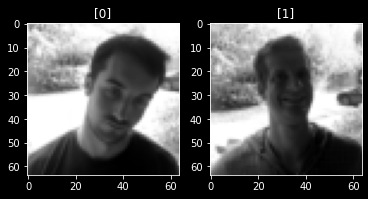

In [2]:
base_path = r"D:\00_MLDL\00_BreadBrother\09_Smile_Face_Detection\dataset"

x_train = np.load(os.path.join(base_path, 'x_train_gray.npy'))
y_train = np.load(os.path.join(base_path, 'y_train_color.npy'))
x_test = np.load(os.path.join(base_path, 'x_test_gray.npy'))
y_test = np.load(os.path.join(base_path, 'y_test_color.npy'))

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

plt.subplot(1, 2, 1)
plt.title(y_train[0])
plt.imshow(x_train[0], cmap='gray')
plt.subplot(1, 2, 2)
plt.title(y_train[1])
plt.imshow(x_train[1], cmap='gray')

## Image Data 늘리기
 - reshaping
 - ImageDataGenerator 사용

In [3]:
x_train = x_train.reshape((-1, 64, 64, 1))
x_test = x_test.reshape((-1, 64, 64, 1))

# Option Mixing
train_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    brightness_range=[0.5, 1.3],
    zoom_range=[0.8, 1.2],
    rotation_range=15.,
    channel_shift_range=50,
    horizontal_flip=True,
    )

test_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    )

train_batch_gen = train_datagen.flow(
    x_train, 
    y_train, 
    batch_size=16, 
    shuffle=True,
    # save_to_dir = os.path.join(base_path, r"imgdatgen\train"),
    # save_prefix = "gen",
    # save_format = "jpg",
    )
test_batch_gen = test_datagen.flow(
    x_test, 
    y_test, 
    batch_size=16, 
    shuffle=False,
    # save_to_dir = os.path.join(base_path, r"imgdatgen\test"),
    # save_prefix = "gen",
    # save_format = "jpg",
    )

print(f"Training In/Out shape: {x_train.shape}/{y_train.shape}")
print(f"Test In/Out shape: {x_test.shape}/{y_test.shape}")

# (16, 64, 64 , 1) batchSize, imgSize
print(f"Training Batch Length/Size: {len(train_batch_gen)}/{len(train_batch_gen[0][0])}")
print(f"Test Batch Length/Size: {len(test_batch_gen)}/{len(test_batch_gen[0][0])}")

# 16*38 = 600, 38-Batch  X (16, 64, 64 , 1) batchSize, imgSize
print(f"Last Training Batch Size: {len(train_batch_gen[37][0])}") 

# 144+6 = 150, 10-Batch X (16, 64, 64 , 1) batchSize, imgSize
print(f"Last Test Batch Size: {len(test_batch_gen[9][0])}")


Training In/Out shape: (600, 64, 64, 1)/(600, 1)
Test In/Out shape: (150, 64, 64, 1)/(150, 1)
Training Batch Length/Size: 38/16
Test Batch Length/Size: 10/16
Last Training Batch Size: 8
Last Test Batch Size: 6


## 여러가지 Case 변화주면서 Model Test
 - Epoch
 - Optimizer
 - Loss

In [13]:
BATCH_SIZE = 16
EPOCHS = [300]
OPTIMIZERS = ['adam', 'adamax', 'nadam']
LOSS = ['binary_crossentropy']
CASE = list(product(EPOCHS, OPTIMIZERS, LOSS))

MODEL_PATH = r"D:\00_MLDL\00_BreadBrother\09_Smile_Face_Detection\models"  
LOG_DIR = r"D:\00_MLDL\00_BreadBrother\09_Smile_Face_Detection\myLog"

##-----------------------------------------------------------------------------------------------------##
## Sequential Model Case
##-----------------------------------------------------------------------------------------------------##
history = {}
for epochs, opt, loss in CASE:
    ## Save path     
    H5_PATH = os.path.join(MODEL_PATH, f"happy_epoch{epochs}_opt{opt}.h5")

    ## TensorBoard Log path
    DIR_NAME = datetime.datetime.now().strftime("Log_%y%m%d_%H%M")
    DIR_NAME = f"{DIR_NAME}_epoch{epochs}_opt{opt}"
    LOG_PATH = os.path.join(LOG_DIR, DIR_NAME)
    tensorboard_callbacks = TensorBoard(log_dir=LOG_PATH, histogram_freq=1)

    ## Model
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=3, strides=2, padding='same', input_shape=(64,64,1)))
    model.add(LeakyReLU())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=opt, loss=loss, metrics=['acc'])
    # print(model.summary())
    
    ## Training
    history[f"{epochs}_{opt}_{loss}"] = model.fit_generator(
        train_batch_gen,
        steps_per_epoch= x_train.shape[0] // BATCH_SIZE, # Automatic calculation
        epochs=epochs,
        validation_data=test_batch_gen,
        callbacks=[
        tensorboard_callbacks,
        ModelCheckpoint(H5_PATH, monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, verbose=1, mode='auto', min_lr=1e-05)
        ]
    )

2667
Epoch 32/300
37/37 [==============================] - 0s 8ms/step - loss: 0.1925 - acc: 0.9281 - val_loss: 0.3021 - val_acc: 0.9200

Epoch 00032: val_acc did not improve from 0.92667

Epoch 00032: ReduceLROnPlateau reducing learning rate to 8.000000379979611e-05.
Epoch 33/300
37/37 [==============================] - 0s 8ms/step - loss: 0.2325 - acc: 0.9212 - val_loss: 0.2444 - val_acc: 0.9267

Epoch 00033: val_acc did not improve from 0.92667
Epoch 34/300
37/37 [==============================] - 0s 8ms/step - loss: 0.1995 - acc: 0.9264 - val_loss: 0.2407 - val_acc: 0.9200

Epoch 00034: val_acc did not improve from 0.92667
Epoch 35/300
37/37 [==============================] - 0s 8ms/step - loss: 0.2059 - acc: 0.9195 - val_loss: 0.2413 - val_acc: 0.9267

Epoch 00035: val_acc did not improve from 0.92667
Epoch 36/300
37/37 [==============================] - 0s 8ms/step - loss: 0.1733 - acc: 0.9349 - val_loss: 0.2385 - val_acc: 0.9267

Epoch 00036: val_acc did not improve from 0.92667

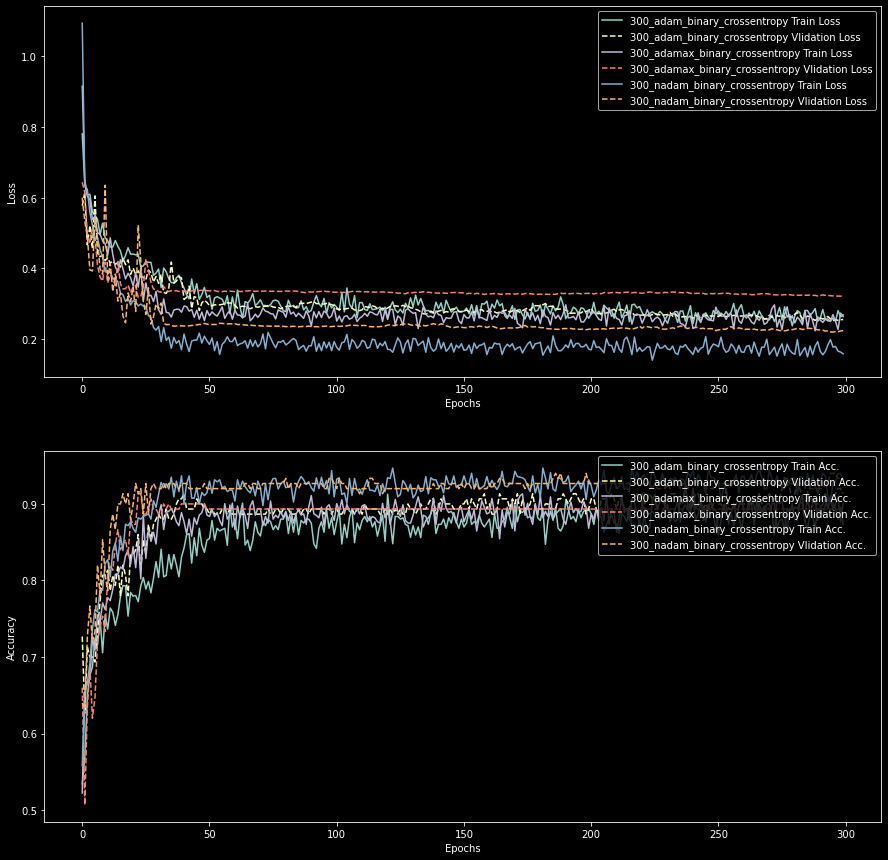

In [42]:
plt.figure(figsize=(15,15))
fig1 = plt.subplot(2,1,1)
fig2 = plt.subplot(2,1,2)
for epochs, opt, loss in CASE:
    label_key = f"{epochs}_{opt}_{loss}"
    fig1.plot(np.arange(0,epochs), history[label_key].history["loss"], '-', label=f"{label_key} Train Loss")
    fig1.plot(np.arange(0,epochs), history[label_key].history["val_loss"], '--', label=f"{label_key} Vlidation Loss")
    fig1.set_xlabel("Epochs")
    fig1.set_ylabel("Loss")
    fig1.legend(loc = "upper right")

    fig2.plot(np.arange(0,epochs), history[label_key].history["acc"], '-', label=f"{label_key} Train Acc.")
    fig2.plot(np.arange(0,epochs), history[label_key].history["val_acc"], '--', label=f"{label_key} Vlidation Acc.")
    fig2.set_xlabel("Epochs")
    fig2.set_ylabel("Accuracy")
    fig2.legend(loc = "upper right")
    
plt.savefig(os.path.join(LOG_DIR, "Test.png"))
plt.show()

In [38]:
TARGET_FILE = "happy_epoch300_optnadam.h5"
TARGET_PATH = os.path.join(MODEL_PATH, TARGET_FILE)

loadedModel = load_model(TARGET_PATH)
x_test_input = x_test.copy().astype(np.float64)
x_test_input -= np.mean(x_test, keepdims=True)
x_test_input /= (np.std(x_test, keepdims=True) + 1e-6)

y_pred = loadedModel.predict(x_test_input)
y_pred_logical = (y_pred > 0.5).astype(np.int)

test acc: 0.94


<AxesSubplot:>

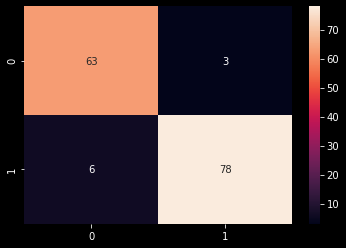

In [39]:
print ('test acc: %s' % accuracy_score(y_test, y_pred_logical))

cm = confusion_matrix(y_test, y_pred_logical)
sns.heatmap(cm, annot=True)

## Ensemble Model
 - Voting

In [7]:
BATCH_SIZE = 16
EPOCHS = [1000]
OPTIMIZERS = ['adam']
LOSS = ['binary_crossentropy']
CASE = list(product(EPOCHS, OPTIMIZERS, LOSS))

MODEL_PATH = r"D:\00_MLDL\00_BreadBrother\09_Smile_Face_Detection\models"  
LOG_DIR = r"D:\00_MLDL\00_BreadBrother\09_Smile_Face_Detection\myLog"

##-----------------------------------------------------------------------------------------------------##
## Ensemble Model, Keras Functional API
##-----------------------------------------------------------------------------------------------------##
def getBaseModel(inputs, opt, loss):
    l1 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(inputs)
    l2 = LeakyReLU()(l1)
    l3 = Flatten()(l2)
    l4 = Dense(64, activation='relu')(l3)
    output = Dense(1, activation='sigmoid')(l4)
    model = Model(input= inputs, output =output)
    model.compile(optimizer=opt, loss=loss, metrics=['acc'])
    return model 
    
def getCustomModel(inputs, opt, loss):
    x = Conv2D(32, kernel_size=3, activation="relu", strides=2, padding='same')(inputs)
    #x = BatchNormalization()(x)
    x = Conv2D(32, kernel_size=3, activation="relu")(x)
    #x = BatchNormalization()(x)
    x = Conv2D(32, kernel_size=5, activation="relu", strides=2, padding='same')(x)
    #x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, kernel_size=3, activation="relu")(x)
    #x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=3, activation="relu")(x)
    #x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=5, activation="relu", strides=2, padding='same')(x)
    #x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, kernel_size=3, activation="relu")(x)
    x = Flatten()(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    #x = Dense(8, activation="relu")(x)
    #x = BatchNormalization()(x)
    #x = Dropout(0.4)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(input = inputs, output = output)
    model.compile(optimizer=opt, loss=loss, metrics=['acc'])
    return model

inputs = Input(shape=(64,64,1))
epochs = EPOCHS[0]
opt = OPTIMIZERS[0]
loss = LOSS[0]

## Define
model_base = getBaseModel(inputs, opt, loss)
model_cnn = getCustomModel(inputs, opt, loss)
#model_base.summary()
#model_cnn.summary()

## Ensemble 
model_ensemble = []
model_ensemble.append(model_base)
model_ensemble.append(model_cnn)

history_ensemble = []
modelTrained_ensemble = []
for i in range(len(model_ensemble)):
    H5_PATH = os.path.join(MODEL_PATH, f"ens_epochs{epochs}_opt{opt}_loss{loss}_{i}.h5")

    ## TensorBoard Log path
    DIR_NAME = datetime.datetime.now().strftime("Log_%y%m%d_%H%M")
    DIR_NAME = f"{DIR_NAME}_epoch{epochs}_opt{opt}_{i}"
    LOG_PATH = os.path.join(LOG_DIR, DIR_NAME)
    tensorboard_callbacks = TensorBoard(log_dir=LOG_PATH, histogram_freq=1)

    history = model_ensemble[i].fit_generator(
        train_batch_gen,
        steps_per_epoch = x_train.shape[0] // BATCH_SIZE, # Automatic calculation
        epochs = epochs,
        validation_data = test_batch_gen,
        callbacks=[
        tensorboard_callbacks,
        ModelCheckpoint(H5_PATH, monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, verbose=1, mode='auto', min_lr=1e-05)
        ]
    )

    history_ensemble.append(history)
    modelTrained_ensemble.append(model_ensemble[i])


00
37/37 [==============================] - 0s 11ms/step - loss: 0.1722 - acc: 0.9288 - val_loss: 0.2801 - val_acc: 0.8933

Epoch 00733: val_acc did not improve from 0.91333
Epoch 734/1000
37/37 [==============================] - 0s 11ms/step - loss: 0.2056 - acc: 0.9189 - val_loss: 0.2993 - val_acc: 0.9000

Epoch 00734: val_acc did not improve from 0.91333
Epoch 735/1000
37/37 [==============================] - 0s 11ms/step - loss: 0.2139 - acc: 0.9201 - val_loss: 0.2895 - val_acc: 0.9000

Epoch 00735: val_acc did not improve from 0.91333
Epoch 736/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.1799 - acc: 0.9298 - val_loss: 0.2602 - val_acc: 0.9000

Epoch 00736: val_acc did not improve from 0.91333
Epoch 737/1000
37/37 [==============================] - 0s 11ms/step - loss: 0.2012 - acc: 0.9075 - val_loss: 0.2628 - val_acc: 0.9000

Epoch 00737: val_acc did not improve from 0.91333
Epoch 738/1000
37/37 [==============================] - 0s 11ms/step - loss: 0.187

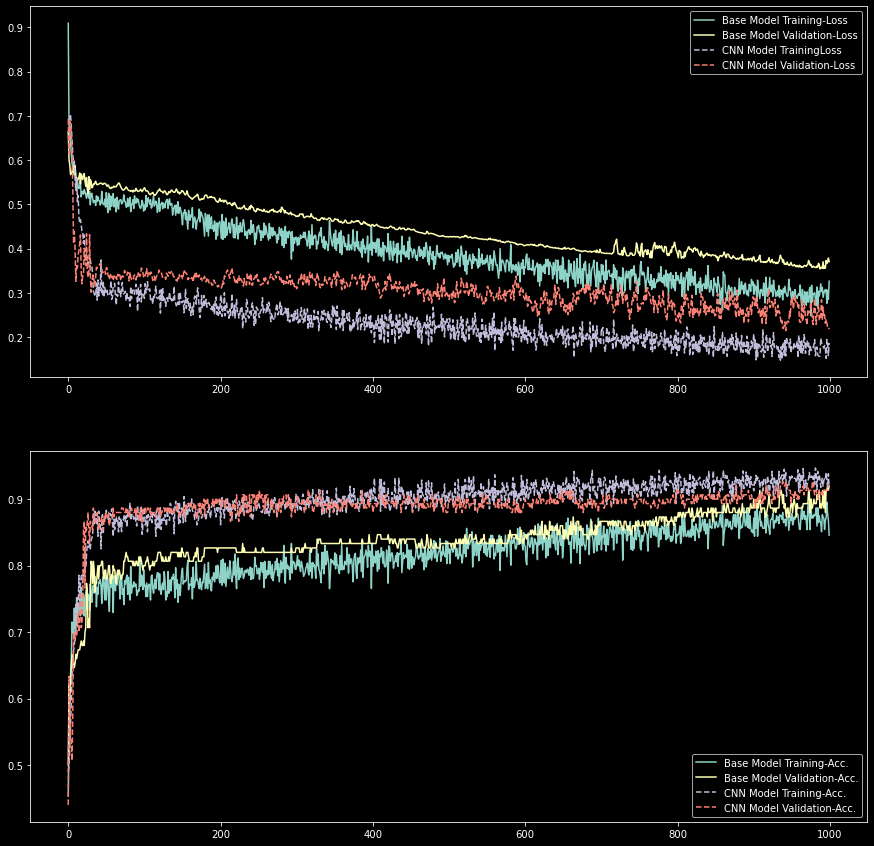

In [8]:
fig = plt.figure(figsize=(15,15))
fig1 = plt.subplot(211)
fig2 = plt.subplot(212)

fig1.plot(np.arange(0,epochs), history_ensemble[0].history['loss'], '-', label = "Base Model Training-Loss")
fig1.plot(np.arange(0,epochs), history_ensemble[0].history['val_loss'], '-', label = "Base Model Validation-Loss")
fig1.plot(np.arange(0,epochs), history_ensemble[1].history['loss'], '--', label = "CNN Model TrainingLoss")
fig1.plot(np.arange(0,epochs), history_ensemble[1].history['val_loss'], '--', label = "CNN Model Validation-Loss")
fig1.legend(loc = "upper right")

fig2.plot(np.arange(0,epochs), history_ensemble[0].history['acc'], '-', label = "Base Model Training-Acc.")
fig2.plot(np.arange(0,epochs), history_ensemble[0].history['val_acc'], '-', label = "Base Model Validation-Acc.")
fig2.plot(np.arange(0,epochs), history_ensemble[1].history['acc'], '--', label = "CNN Model Training-Acc.")
fig2.plot(np.arange(0,epochs), history_ensemble[1].history['val_acc'], '--', label = "CNN Model Validation-Acc.")
fig2.legend(loc = "lower right")

### Voting

Base model test score: 0.89
CNN model test score: 0.77
Ensemble model test score: 0.86


<AxesSubplot:title={'center':'Ensemble'}>

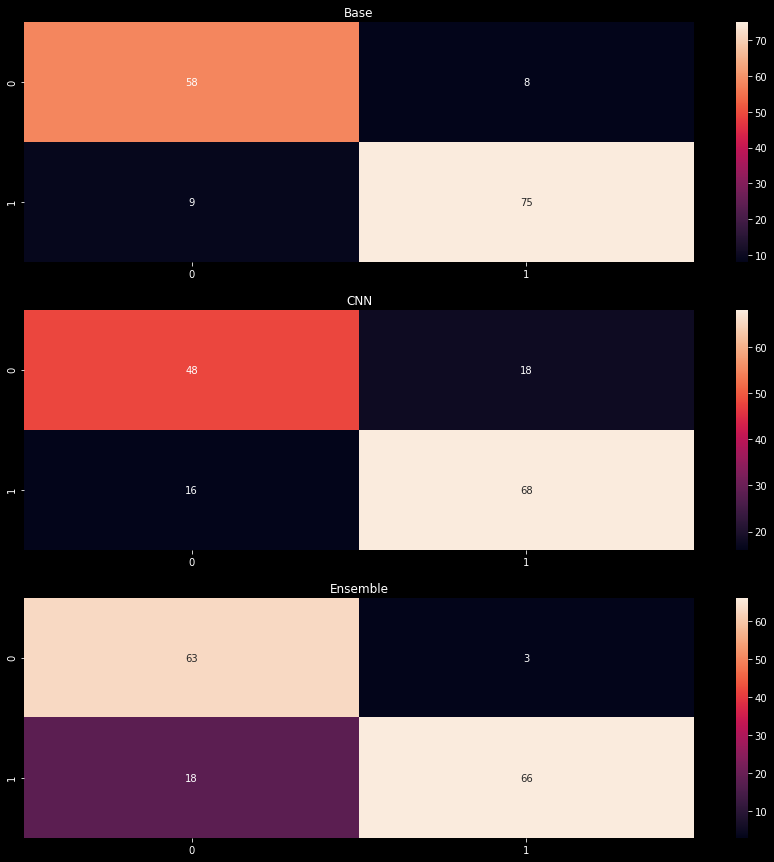

In [9]:
labels = []
labels_logic = []
y_preds_digital = []

x_test_input = x_test.copy().astype(np.float64)
x_test_input -= np.mean(x_test, keepdims=True)
x_test_input /= (np.std(x_test, keepdims=True) + 1e-6)

for m in modelTrained_ensemble:
    y_pred = m.predict(x_test_input).flatten() # (150,)
    y_pred_logical = (y_pred > 0.5).astype(np.int)
    y_preds_digital.append(y_pred_logical)
    labels.append(y_pred)
    labels_logic.append(y_pred_logical)

## Floating number
labels = np.array(labels) # (2,150)
labels = np.transpose(labels, (1,0)) # 150,2

## Voting
labels = scipy.stats.mode(labels, axis=1)[0] # smallest value, Voting
labels = np.squeeze(labels)
labels_processed_logic = (labels > 0.5).astype(np.int)

## Digital Number
labels_logic = np.array(labels_logic).reshape(2,150,)
labels_logic = np.transpose(labels_logic, (1,0))

## Voting
labels_logic = scipy.stats.mode(labels_logic, axis=1)[0] # smallest value
labels_logic = np.squeeze(labels_logic)

## Accuracy Calculation
print(f"Base model test score: {accuracy_score(y_test, y_preds_digital[0]):.2f}")
print(f"CNN model test score: {accuracy_score(y_test, y_preds_digital[1]):.2f}")
print(f"Ensemble model test score: {accuracy_score(y_test, labels_logic):.2f}")


cmap_en = confusion_matrix(y_test, labels_logic)
cmap_base = confusion_matrix(y_test, y_preds_digital[0])
cmap_cnn = confusion_matrix(y_test, y_preds_digital[1])
plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
plt.title("Base")
sns.heatmap(cmap_base, annot=True)

plt.subplot(3,1,2)
plt.title("CNN")
sns.heatmap(cmap_cnn, annot=True)

plt.subplot(3,1,3)
plt.title("Ensemble")
sns.heatmap(cmap_en, annot=True)
